In [1]:
import torch
import os
import pandas as pd
import numpy as np
from utils.config import config_dataset
from utils.helper import ObjectView
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from utils.utils_gan_wasserstein import Discriminator_wassertein, Generator_linear, plot_GAN_loss, fit_gan_wasserstein, build_gan_scenarios
from utils.utils_vae import *

# Set the torch seed for result reproducibility
torch_seed = 3307
torch.manual_seed(torch_seed)

In [2]:
indices = []
non_null_indexes = list(np.delete(np.asarray([i for i in range(96)]), indices))
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

X_train = torch.load("../data/london/tensor_small/y_tr.pt", weights_only=True)
X_test = torch.load("../data/london/tensor_small/y_val.pt", weights_only=True)
cond_train = torch.load("../data/london/tensor_small/X_tr.pt", weights_only=True)
cond_test = torch.load("../data/london/tensor_small/X_val.pt", weights_only=True)
print(X_train.shape)
print(X_test.shape)
print(cond_train.shape)
print(cond_test.shape)

X_train, X_val, cond_train, cond_val = train_test_split(X_train, cond_train, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, cond_train.shape, cond_test.shape, X_val.shape, cond_val.shape

y_LS_scaler = StandardScaler()
y_LS_scaler.fit(X_train)
y_LS_scaled = y_LS_scaler.transform(X_train)
y_VS_scaled = y_LS_scaler.transform(X_val)
y_TEST_scaled = y_LS_scaler.transform(X_test)

x_LS_scaler = StandardScaler()
x_LS_scaler.fit(cond_train)
x_LS_scaled = x_LS_scaler.transform(cond_train)
x_VS_scaled = x_LS_scaler.transform(cond_val)
x_TEST_scaled = x_LS_scaler.transform(cond_test)

torch.Size([16696, 48])
torch.Size([4174, 48])
torch.Size([16696, 81])
torch.Size([4174, 81])


In [3]:
# n_s = 100 # num of samples
n_s = 20
N_q = 48
# semble un bon set de hp mais d'un calcul a l'autre les résultats changent bcp ...
nb_epoch = 200

cf_VAE = {
    'name': 'VAElinear_1',
    'latent_s': 5,
    'enc_w': 500,
    'enc_l': 1,
    'dec_w': 500,
    'dec_l': 1,
    'weight_decay': 10 ** (-4),
    'learning_rate': 10 ** (-3.9),
}

print('VAE latent_s %s enc_w %s enc_l %s dec_w %s dec_l %s weight_decay %.4e lr %.4e' % (cf_VAE['latent_s'], cf_VAE['enc_w'], cf_VAE['enc_l'], cf_VAE['dec_w'], cf_VAE['dec_l'], cf_VAE['weight_decay'], cf_VAE['learning_rate']))


VAE latent_s 5 enc_w 500 enc_l 1 dec_w 500 dec_l 1 weight_decay 1.0000e-04 lr 1.2589e-04


In [4]:
# Set the VAE configuration
config = cf_VAE
tag = "load"

# --------------------------------------------------------------------------------------------------------------
# Build the VAE
# --------------------------------------------------------------------------------------------------------------

config['in_size'] = y_LS_scaled.shape[1]
config['cond_in'] = x_LS_scaled.shape[1]


VAE_model = VAElinear(latent_s=config['latent_s'], cond_in=config['cond_in'], in_size=config['in_size'], enc_w=config['enc_w'], enc_l=config['enc_l'], dec_w=config['dec_w'], dec_l=config['dec_l'], gpu=True)
opt = torch.optim.Adam(VAE_model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

In [5]:
# --------------------------------------------------------------------------------------------------------------
# Fit the VAE
# --------------------------------------------------------------------------------------------------------------
print('Fit VAE with %s epochs' % (nb_epoch))
training_time = 0.
start = timer()
loss, best_vae, last_vae = fit_VAE(nb_epoch=nb_epoch, x_LS=x_LS_scaled, y_LS=y_LS_scaled, x_VS=x_VS_scaled,
                                    y_VS=y_VS_scaled, x_TEST=x_TEST_scaled, y_TEST=y_TEST_scaled,
                                    model=VAE_model,
                                    opt=opt, gpu=True)
end = timer()
training_time += end - start
print('Training time %.2f s' %(training_time))
epoch_min = np.nanargmin(loss[:, 1])
print('epoch %s ll VS is min = %.2f ll TEST = %.2f' % (epoch_min, loss[epoch_min, 1], loss[epoch_min, 2]))


Fit VAE with 200 epochs
Fitting time_tot 0 mintime left : 0.003017 min - LS loss: 16.910007 VS loss: 16.843018 TEST loss: 17.370268
Training time 4.13 s
epoch 197 ll VS is min = 16.83 ll TEST = 17.32


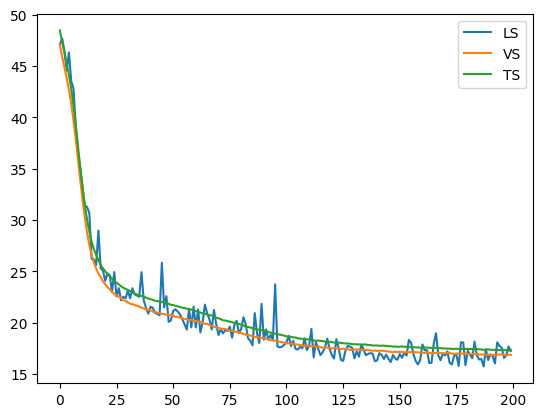

In [6]:
plt.figure()
plt.plot(loss[:, 0], label='LS')
plt.plot(loss[:, 1], label='VS')
plt.plot(loss[:, 2], label='TS')
plt.legend()

In [7]:
# --------------------------------------------------------------------------------------------------------------
# Build scenarios on VS & TEST
# --------------------------------------------------------------------------------------------------------------

# best_flow = read_file(dir=dir_path, name=name)
max_power = 1
# Scenarios are generated into a dict of length nb days (#VS or # TEST sizes)
# Each day of the dict is an array of shape (n_scenarios, 24)
generation_time = 0.
start = timer()
    # s_LS = build_vae_scenarios(n_s=n_s, x=x_LS_scaled, y_scaler=y_LS_scaler, model=best_vae, max=max_power, gpu=gpu, tag=tag, non_null_indexes=non_null_indexes)
s_TEST = build_vae_scenarios(n_s=n_s, x=x_TEST_scaled, y_scaler=y_LS_scaler, model=best_vae, max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
s_VS = build_vae_scenarios(n_s=n_s, x=x_VS_scaled, y_scaler=y_LS_scaler, model=best_vae, max=max_power, gpu=True, tag=tag, non_null_indexes=non_null_indexes)
end = timer()
generation_time += end - start
print('Generation time (LS, VS, TEST) %.2f s' %(generation_time))

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [8]:
X_test_hat = s_TEST.reshape(-1, 48, s_TEST.shape[-1])
X_test_hat = torch.tensor(X_test_hat).permute(0, 2, 1)

In [9]:
torch.save(X_test_hat, "../result/data/london/load_hat_vae.pt")

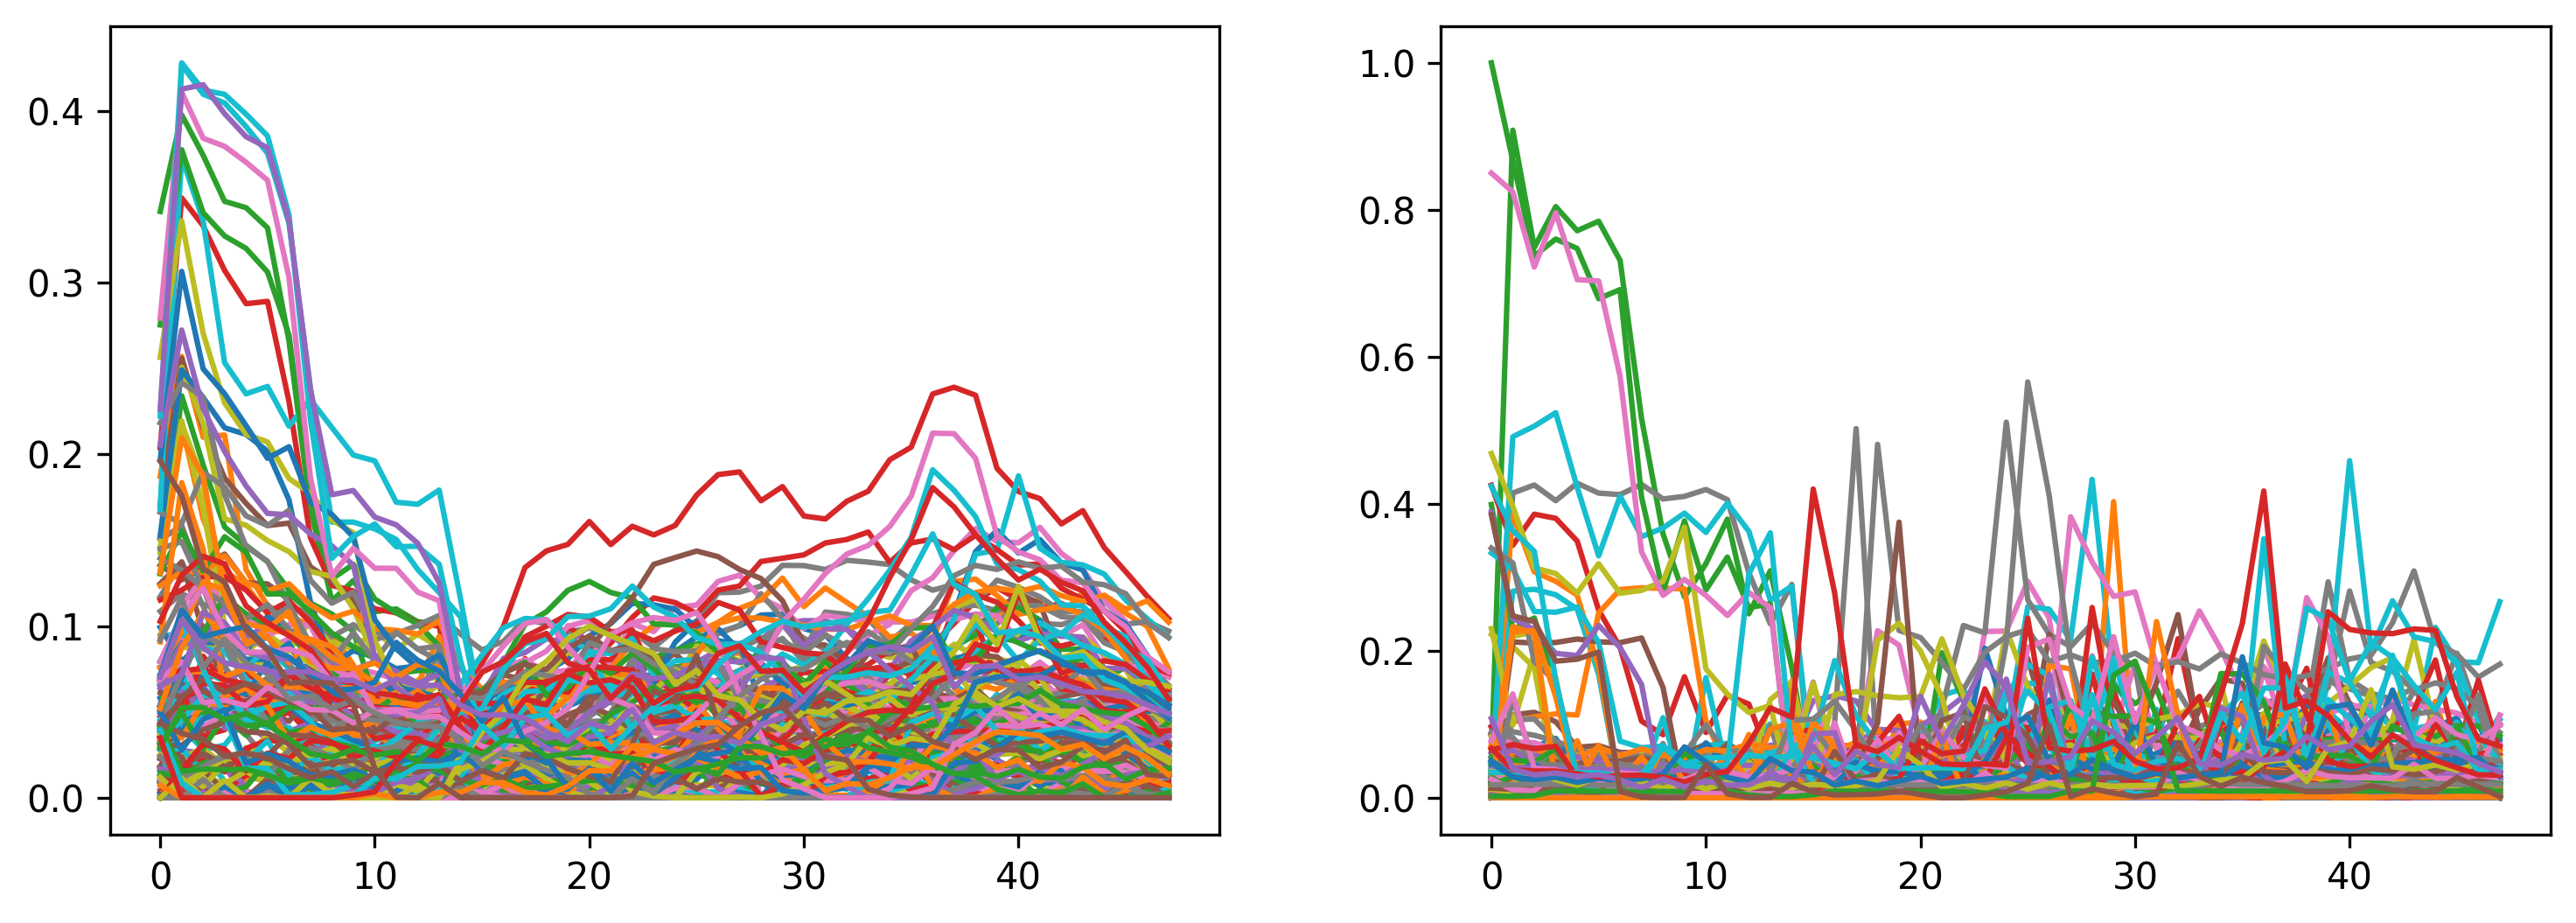

In [10]:
user = 0
plt.figure(figsize=(12,4), dpi=300)
plt.subplot(1,2,1)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test_hat[i, 0, :])
plt.subplot(1,2,2)
for i in range(146*user, 146*(user+1)):
    plt.plot(X_test[i])

In [11]:
# n = 20
# plt.figure(figsize=(20,20), dpi=300)
# for j in range(n):
#     plt.subplot(int(n/4), 4, j+1)
#     j = j + 200
#     for i in range(10):
#         plt.plot(X_test_hat[j][i], color='gray')
#     plt.plot(X_test[j])